In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
dir_name = "/content/gdrive/My Drive/ColabData/handwritten/"

In [4]:
import pandas as pd
import os
import pickle
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from keras.preprocessing.image import load_img, img_to_array
from keras import models
from keras import layers
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop

In [5]:
numOfTrainImage = 60000
mini_batch = 64
max_epoch = 100
numOfTestImage = 10000

dropout_rate = 0.4

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')

filename_train_images   = "x_train.npy"
filename_train_category = "y_train.npy"
filename_test_images    = "x_test.npy"
filename_test_filelist  = "filelist_test.txt"

In [6]:
print(os.listdir(dir_name))

['train_master.tsv', 'y_train.npy', 'x_train.npy', 'filelist_test.txt', 'x_test.npy', 'submit.tsv']


In [7]:
df = pd.read_csv(os.path.join(dir_name, 'train_master.tsv'), delimiter='\t')
df.head(5)

,file_name,category_id
0,train_0.jpg,5
1,train_1.jpg,0
2,train_2.jpg,4
3,train_3.jpg,1
4,train_4.jpg,9


In [8]:
x_train = np.load(os.path.join(dir_name, filename_train_images))
t_train = np.load(os.path.join(dir_name, filename_train_category))

x_train = x_train[0:numOfTrainImage]
t_train = t_train[0:numOfTrainImage]

x_train, x_valid, t_train, t_valid = train_test_split(x_train, t_train, test_size=0.5, random_state=0)

print("x_train.shape = ", x_train.shape, "t_train.shape = ", t_train.shape)
print("x_valid.shape = ", x_valid.shape, "t_valid.shape = ", t_valid.shape)

x_train.shape =  (30000, 28, 28, 1) t_train.shape =  (30000,)
x_valid.shape =  (30000, 28, 28, 1) t_valid.shape =  (30000,)


In [9]:
network = models.Sequential()

network.add(layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), padding='same', data_format="channels_last", input_shape=(28, 28, 1)))
network.add(layers.BatchNormalization())
network.add(layers.Activation('relu'))
network.add(layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), padding='same'))
network.add(layers.BatchNormalization())
network.add(layers.Activation('relu'))
network.add(layers.MaxPooling2D(pool_size=(2,2), strides=None))
network.add(layers.Dropout(dropout_rate))

network.add(layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
network.add(layers.BatchNormalization())
network.add(layers.Activation('relu'))
network.add(layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
network.add(layers.BatchNormalization())
network.add(layers.Activation('relu'))
network.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
network.add(layers.Dropout(dropout_rate))

network.add(layers.Flatten())
network.add(layers.Dense(256, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 28, 28, 32)        0

In [11]:
history = network.fit(x_train, to_categorical(t_train), epochs=max_epoch, batch_size=mini_batch, validation_data=(x_valid, to_categorical(t_valid)), callbacks=[early_stopping])

Epoch 1/100
469/469 [==============================] - 25s 17ms/step - loss: 0.4881 - accuracy: 0.8476 - val_loss: 0.9312 - val_accuracy: 0.7212
Epoch 2/100
469/469 [==============================] - 7s 16ms/step - loss: 0.1681 - accuracy: 0.9483 - val_loss: 0.1078 - val_accuracy: 0.9679
Epoch 3/100
469/469 [==============================] - 7s 15ms/step - loss: 0.1178 - accuracy: 0.9633 - val_loss: 0.0778 - val_accuracy: 0.9764
Epoch 4/100
469/469 [==============================] - 7s 16ms/step - loss: 0.0957 - accuracy: 0.9697 - val_loss: 0.0532 - val_accuracy: 0.9832
Epoch 5/100
469/469 [==============================] - 7s 16ms/step - loss: 0.0856 - accuracy: 0.9724 - val_loss: 0.0490 - val_accuracy: 0.9849
Epoch 6/100
469/469 [==============================] - 6s 13ms/step - loss: 0.0696 - accuracy: 0.9798 - val_loss: 0.0523 - val_accuracy: 0.9839
Epoch 7/100
469/469 [==============================] - 6s 13ms/step - loss: 0.0679 - accuracy: 0.9788 - val_loss: 0.0369 - val_accuracy

In [12]:
acc_train  = np.array(history.history['accuracy'])
acc_valid  = history.history['val_accuracy']
loss_train = history.history['loss']
loss_valid = history.history['val_loss']

f = open('temp_epoch_loss.dat', 'w')
for n in range(0,len(acc_train)):
  f.write(str(n) + ' ' + str(acc_train[n]) + ' ' + str(loss_train[n]) + ' ' + str(acc_valid[n]) + ' ' + str(loss_valid[n]) + '\n')
f.close()

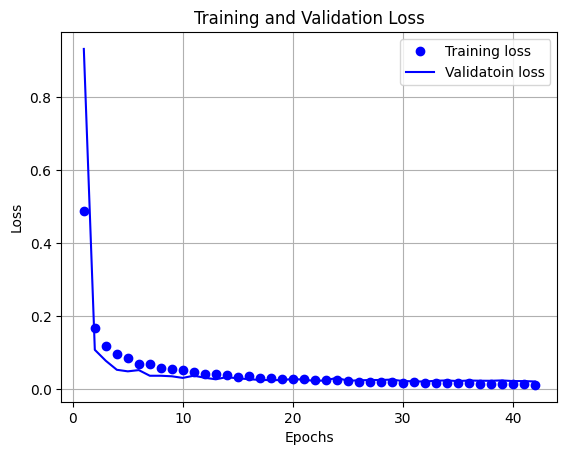

In [13]:
import matplotlib.pyplot as plt

epochs = range(1, len(loss_train) + 1)
plt.plot(epochs, loss_train, 'bo', label='Training loss')
plt.plot(epochs, loss_valid, 'b',  label='Validatoin loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

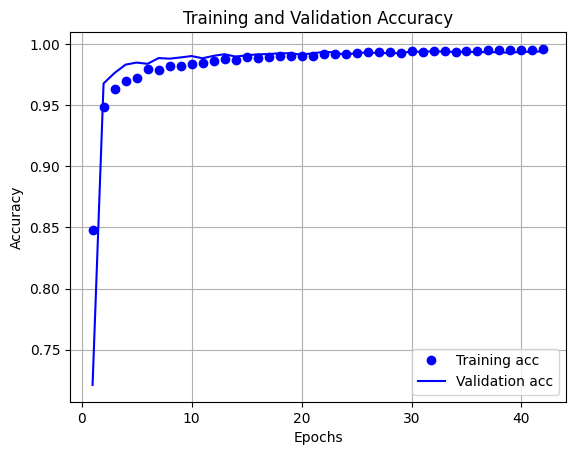

In [14]:
plt.plot(epochs, acc_train, 'bo', label='Training acc')
plt.plot(epochs, acc_valid, 'b',  label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [15]:
y_predict = np.argmax(network.predict(x_train), axis=-1)
confusion = confusion_matrix(t_train, y_predict)
score = accuracy_score(t_train, y_predict)
print("Accuracy Score   on train set: ", score)
print("Confusion Matrix on train set:\n{}".format(confusion))

y_predict = np.argmax(network.predict(x_valid), axis=-1)
confusion = confusion_matrix(t_valid, y_predict)
score = accuracy_score(t_valid, y_predict)
print("Accuracy Score   on valid set: ", score)
print("Confusion Matrix on valid set:\n{}".format(confusion))

938/938 [==============================] - 2s 2ms/step
Accuracy Score   on train set:  0.9996666666666667
Confusion Matrix on train set:
[[3034    0    0    0    0    0    0    0    0    0]
 [   0 3325    0    0    0    0    0    0    1    0]
 [   0    0 3077    0    0    0    0    0    0    0]
 [   0    0    0 3141    0    1    0    0    0    1]
 [   0    0    0    0 2909    0    0    0    0    0]
 [   0    0    0    2    0 2671    0    0    0    0]
 [   0    0    0    0    0    0 2955    0    0    0]
 [   0    2    0    0    0    0    0 3029    1    0]
 [   0    0    0    0    0    0    0    0 2928    0]
 [   0    0    0    0    2    0    0    0    0 2921]]
938/938 [==============================] - 3s 3ms/step
Accuracy Score   on valid set:  0.9942666666666666
Confusion Matrix on valid set:
[[2883    0    1    0    0    0    4    0    1    0]
 [   0 3407    3    0    0    1    2    3    0    0]
 [   2    3 2862    2    1    0    0    7    3    1]
 [   0    0    2 2973    0    5    0

In [16]:
x_test = np.load(os.path.join(dir_name, filename_test_images))
print(x_test.shape)

f = open(os.path.join(dir_name, filename_test_filelist), "rb")
filenamearray = pickle.load(f)

(10000, 28, 28, 1)


In [17]:
y_test = network.predict(x_test)
numOfImages, dummy = y_test.shape

#for n in range(0, numOfImages):
#  print(filenamearray[n], end='')
#  for k in range(0,10):
#    print('%6.3f' % y_test[n][k], end='')
#  print()

y_test_class = np.argmax(y_test, axis=-1)

f = open(os.path.join(dir_name, 'submit.tsv'), 'w')
for n in range(0, numOfImages):
  print(filenamearray[n], y_test_class[n], sep='\t', file=f)
f.close()

313/313 [==============================] - 1s 3ms/step
